## Results of fixed `decay_val =0.8`

In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from stabnode.utils import set_global_seed
from sympy import symbols, Eq, solve, simplify
from tqdm.auto import tqdm

plt.style.use("ggplot")

device = 'cpu'
set_global_seed(1234)

In [16]:
log_path = "decay_08/log_hist.pkl"

with open(log_path, 'rb') as file:
    log = pickle.load(file)

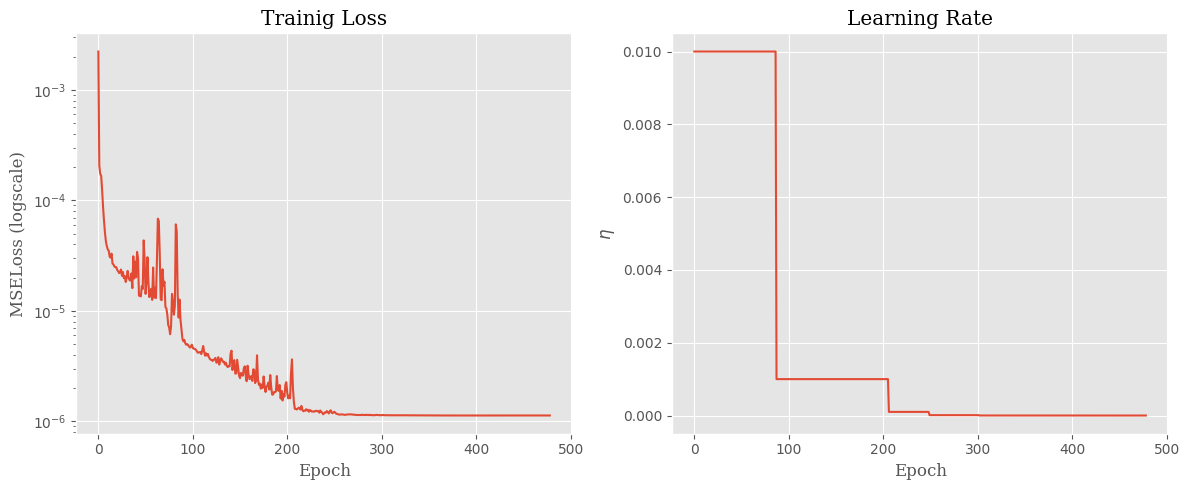

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(log["losses"])
ax1.set_yscale("log")
ax1.set_ylabel("MSELoss (logscale)", family='serif')
ax1.set_xlabel("Epoch", family='serif')
ax1.set_title("Trainig Loss", family='serif')

ax2.plot(log["lr_hist"])
ax2.set_ylabel(r"$\eta$")
ax2.set_xlabel("Epoch", family='serif')
ax2.set_title("Learning Rate", family='serif')


plt.tight_layout()
plt.show()

# Load Model

In [18]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLPfeaturized, StabNODE

In [19]:
model_path = "decay_08/model_opt_states.pt"

In [20]:
config = torch.load(model_path, map_location='cpu', weights_only=False)

In [21]:
config.keys()

dict_keys(['f_state_dict', 'g_state_dict', 'stabnode_state_dict', 'f_args', 'g_args', 'opt_state_dict', 'epoch', 'loss', 'scheduler_state_dict'])

In [22]:
f = FeluSigmoidMLP(
    dims=[1, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-0.5,
    upper_bound=-0.1,
)

g = GeluSigmoidMLPfeaturized(
    dims=[6, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-5,
    upper_bound=1.1,
    freq_sample_step=1,
    feat_lower_bound=0,
    feat_upper_bound=1,
)

model = StabNODE(f,g)

f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])
model.to(device)

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

## Load Data

In [23]:
from sklearn.preprocessing import MinMaxScaler
from data.budworm import simulate_trials
import pandas as pd

In [24]:
from typing import List
class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials: List, t_trials: List, k_trials: List):
        self.x_trials = x_trials
        self.t_trials = t_trials
        self.k_trials = k_trials

    def __len__(self):
        return len(self.x_trials)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {len(self)}."
            )

        Xi = self.x_trials[idx]
        ti = self.t_trials[idx]
        x0 = Xi[0]
        ki = self.k_trials[idx]

        return Xi, ti, x0, ki

In [25]:
r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

6.44569072482332 9.93441120446710


In [27]:
sample_rate = 13
t_span = np.linspace(0,2/2*np.pi,251)
t_trials = t_span[::sample_rate]
k_vals = smooth_k(t_trials)
traj_per_k = 25

xs = np.linspace(0.1, 10, traj_per_k)

trials = {}
for idx, ki in enumerate(tqdm(k_vals, leave=True)):
    ki_traj, ki_times = [], []

    for x0 in tqdm(xs,leave=False):
        trial = simulate_trials(
            [ki],
            x0,
            dt=0.2,
            r=0.56,
            eps=1e-3,
            buffer=1e-1,
            t_max=400,
            n_points=501,
            show_progress=False,
        )
        if len(trial.t_vals[0]) == 1:
            continue
        ki_traj.append(trial.x_vals[0])
        ki_times.append(trial.t_vals[0])

    trials[str(idx)] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki,
        "trial": idx,
    }

trial_df = pd.DataFrame(trials)

# -----------------------------------------------------------------
# SCALING
# -----------------------------------------------------------------
full_traj = [np.concatenate(trial_df[col].traj) for col in trial_df.columns]
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1, 1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_rows[col] = [
        scaler.transform(xi.reshape(-1, 1)).reshape(-1) for xi in traj
    ]
trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

# -----------------------------------------------------------------
# TORCH DATASET PREP
# -----------------------------------------------------------------
all_xs, all_ts, all_ks = [], [], []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [
        torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled
    ]
    ts_torch = [
        torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts
    ]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in ts]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)

train_dataset = TrialsDataset(all_xs, all_ts, all_ks)
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, shuffle=True, batch_size=1, num_workers=0
# )

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## True $g$ and $f$

In [28]:
from data.budworm import g_true, f_true

In [29]:
f_eval  = f.eval()
g_eval = g.eval()
model_eval = StabNODE(f_eval, g_eval)
model_eval.eval()

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

In [30]:
x_lin = np.linspace(0,1,101)
g_preds = []
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    for k in k_vals:
        k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
        g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])
        g_preds.append(g_pred)

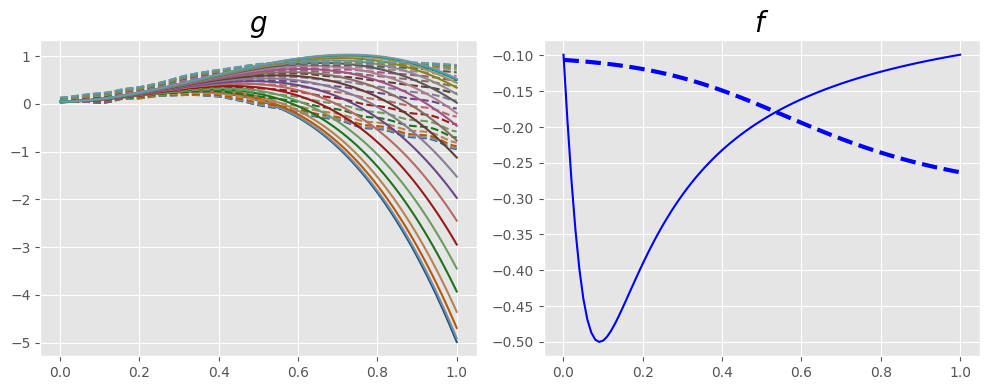

(1.028825481308944, -4.9843281829399695)

In [61]:
import matplotlib.colors as mcolors

colors = list(plt.cm.tab20.colors)

darken_factor = 0.7
darker_colors = [
    (np.array(mcolors.to_rgb(c)) * darken_factor).clip(0, 1)
    for c in colors
]

x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
maxs = []
mins = []
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    maxs.append(g_true_arr.max())
    mins.append(g_true_arr.min())

    ax1.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=darker_colors[idx])
    ax1.plot(x_lin, g_preds[idx],linestyle='--', c=darker_colors[idx])

# ax1.legend(prop={'family':'serif'})

f_true_arr = f_true(x_lin_unscaled)
ax1.set_title(r"$g$",size=20)
ax2.set_title(r"$f$",size=20)
ax2.plot(x_lin, f_true_arr,c='blue')
ax2.plot(x_lin, f_pred,linestyle="--",lw=3,c='blue')
# plt.suptitle(r"$g$ and $f$", size=30, family='serif')
plt.tight_layout()
plt.show()

max(maxs), min(mins)

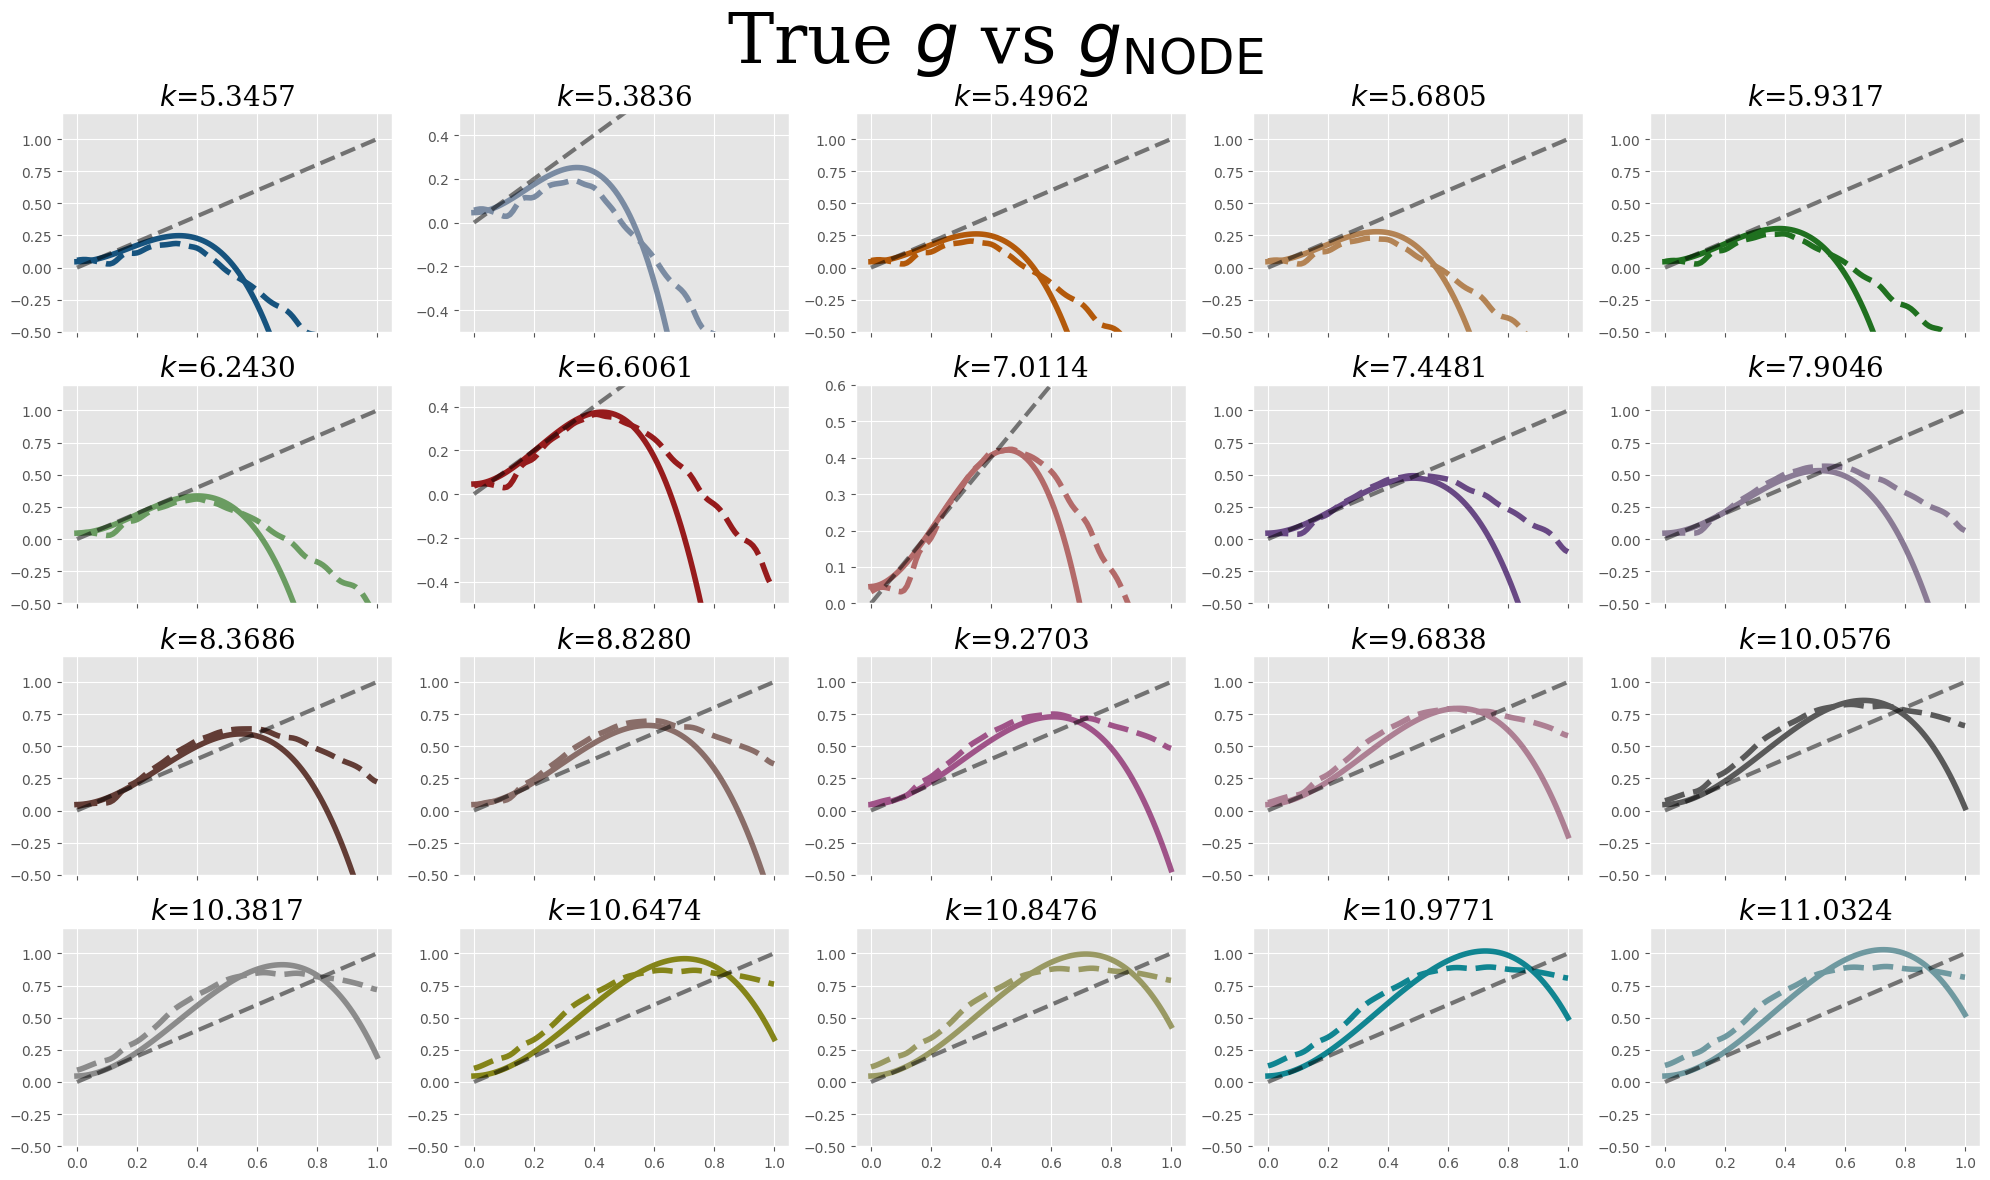

In [55]:
import matplotlib.colors as mcolors
import numpy as np

# Darken factor (e.g., 0.7 makes them 30% darker)
darken_factor = 0.7
darker_colors = [
    (np.array(mcolors.to_rgb(c)) * darken_factor).clip(0, 1)
    for c in colors
]

fig, axes = plt.subplots(4, 5, figsize=(20, 12), sharex=True, sharey=False)
axes = axes.flatten()

for idx, k in enumerate(k_vals):
    ax = axes[idx]
    g_true_arr = scaler.transform(
        g_true(x_lin_unscaled, k, r=0.56).reshape(-1, 1)
    ).reshape(-1)

    ax.set_title(rf"$k$={k:.4f}", family='serif',size=20)
    ax.plot(x_lin, g_true_arr, label=rf"$k$={k}", c=darker_colors[idx],lw=4)
    ax.plot(x_lin, g_preds[idx], linestyle="--", c=darker_colors[idx],lw=4)
    ax.plot(x_lin, x_lin, linestyle="--", c="black", alpha=0.5,lw=3)

    if idx == 1 or idx == 6:
        ax.set_ylim(-0.5, 0.5)
    elif idx == 7:
        ax.set_ylim(0,0.6)
    else:
        ax.set_ylim(-0.5, 1.2)

# remove unused axes if k_vals has fewer than 20
for j in range(len(k_vals), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(r"True $g$ vs $g_{\text{NODE}}$", family='serif',size=50)
plt.tight_layout()
plt.show()


## Plotting Trajectories

In [62]:
from torchode import solve_ivp
from tqdm.auto import tqdm
from data.budworm import budworm_steady_states

In [63]:
indices = [0]
for key, val in trials.items():
    print(val["k"], len(val["traj"]))
    indices.append(len(val["traj"]))

5.34569072482332 25
5.38356069574924 25
5.49616220271546 25
5.68049688022994 25
5.93165624393098 25
6.24295239425651 25
6.60609610257991 25
7.01141753771482 25
7.44812375525898 25
7.90458609332207 25
8.36864982183215 25
8.82795780004423 25
9.27027952386294 25
9.68383680107029 25
10.0576173823423 25
10.3816681966529 25
10.6473603827596 25
10.8476190594836 25
10.9771117164356 25
11.0323902086967 25


In [64]:
indices = np.cumsum(indices)

In [70]:
len(indices)

21

  0%|          | 0/25 [00:00<?, ?it/s]

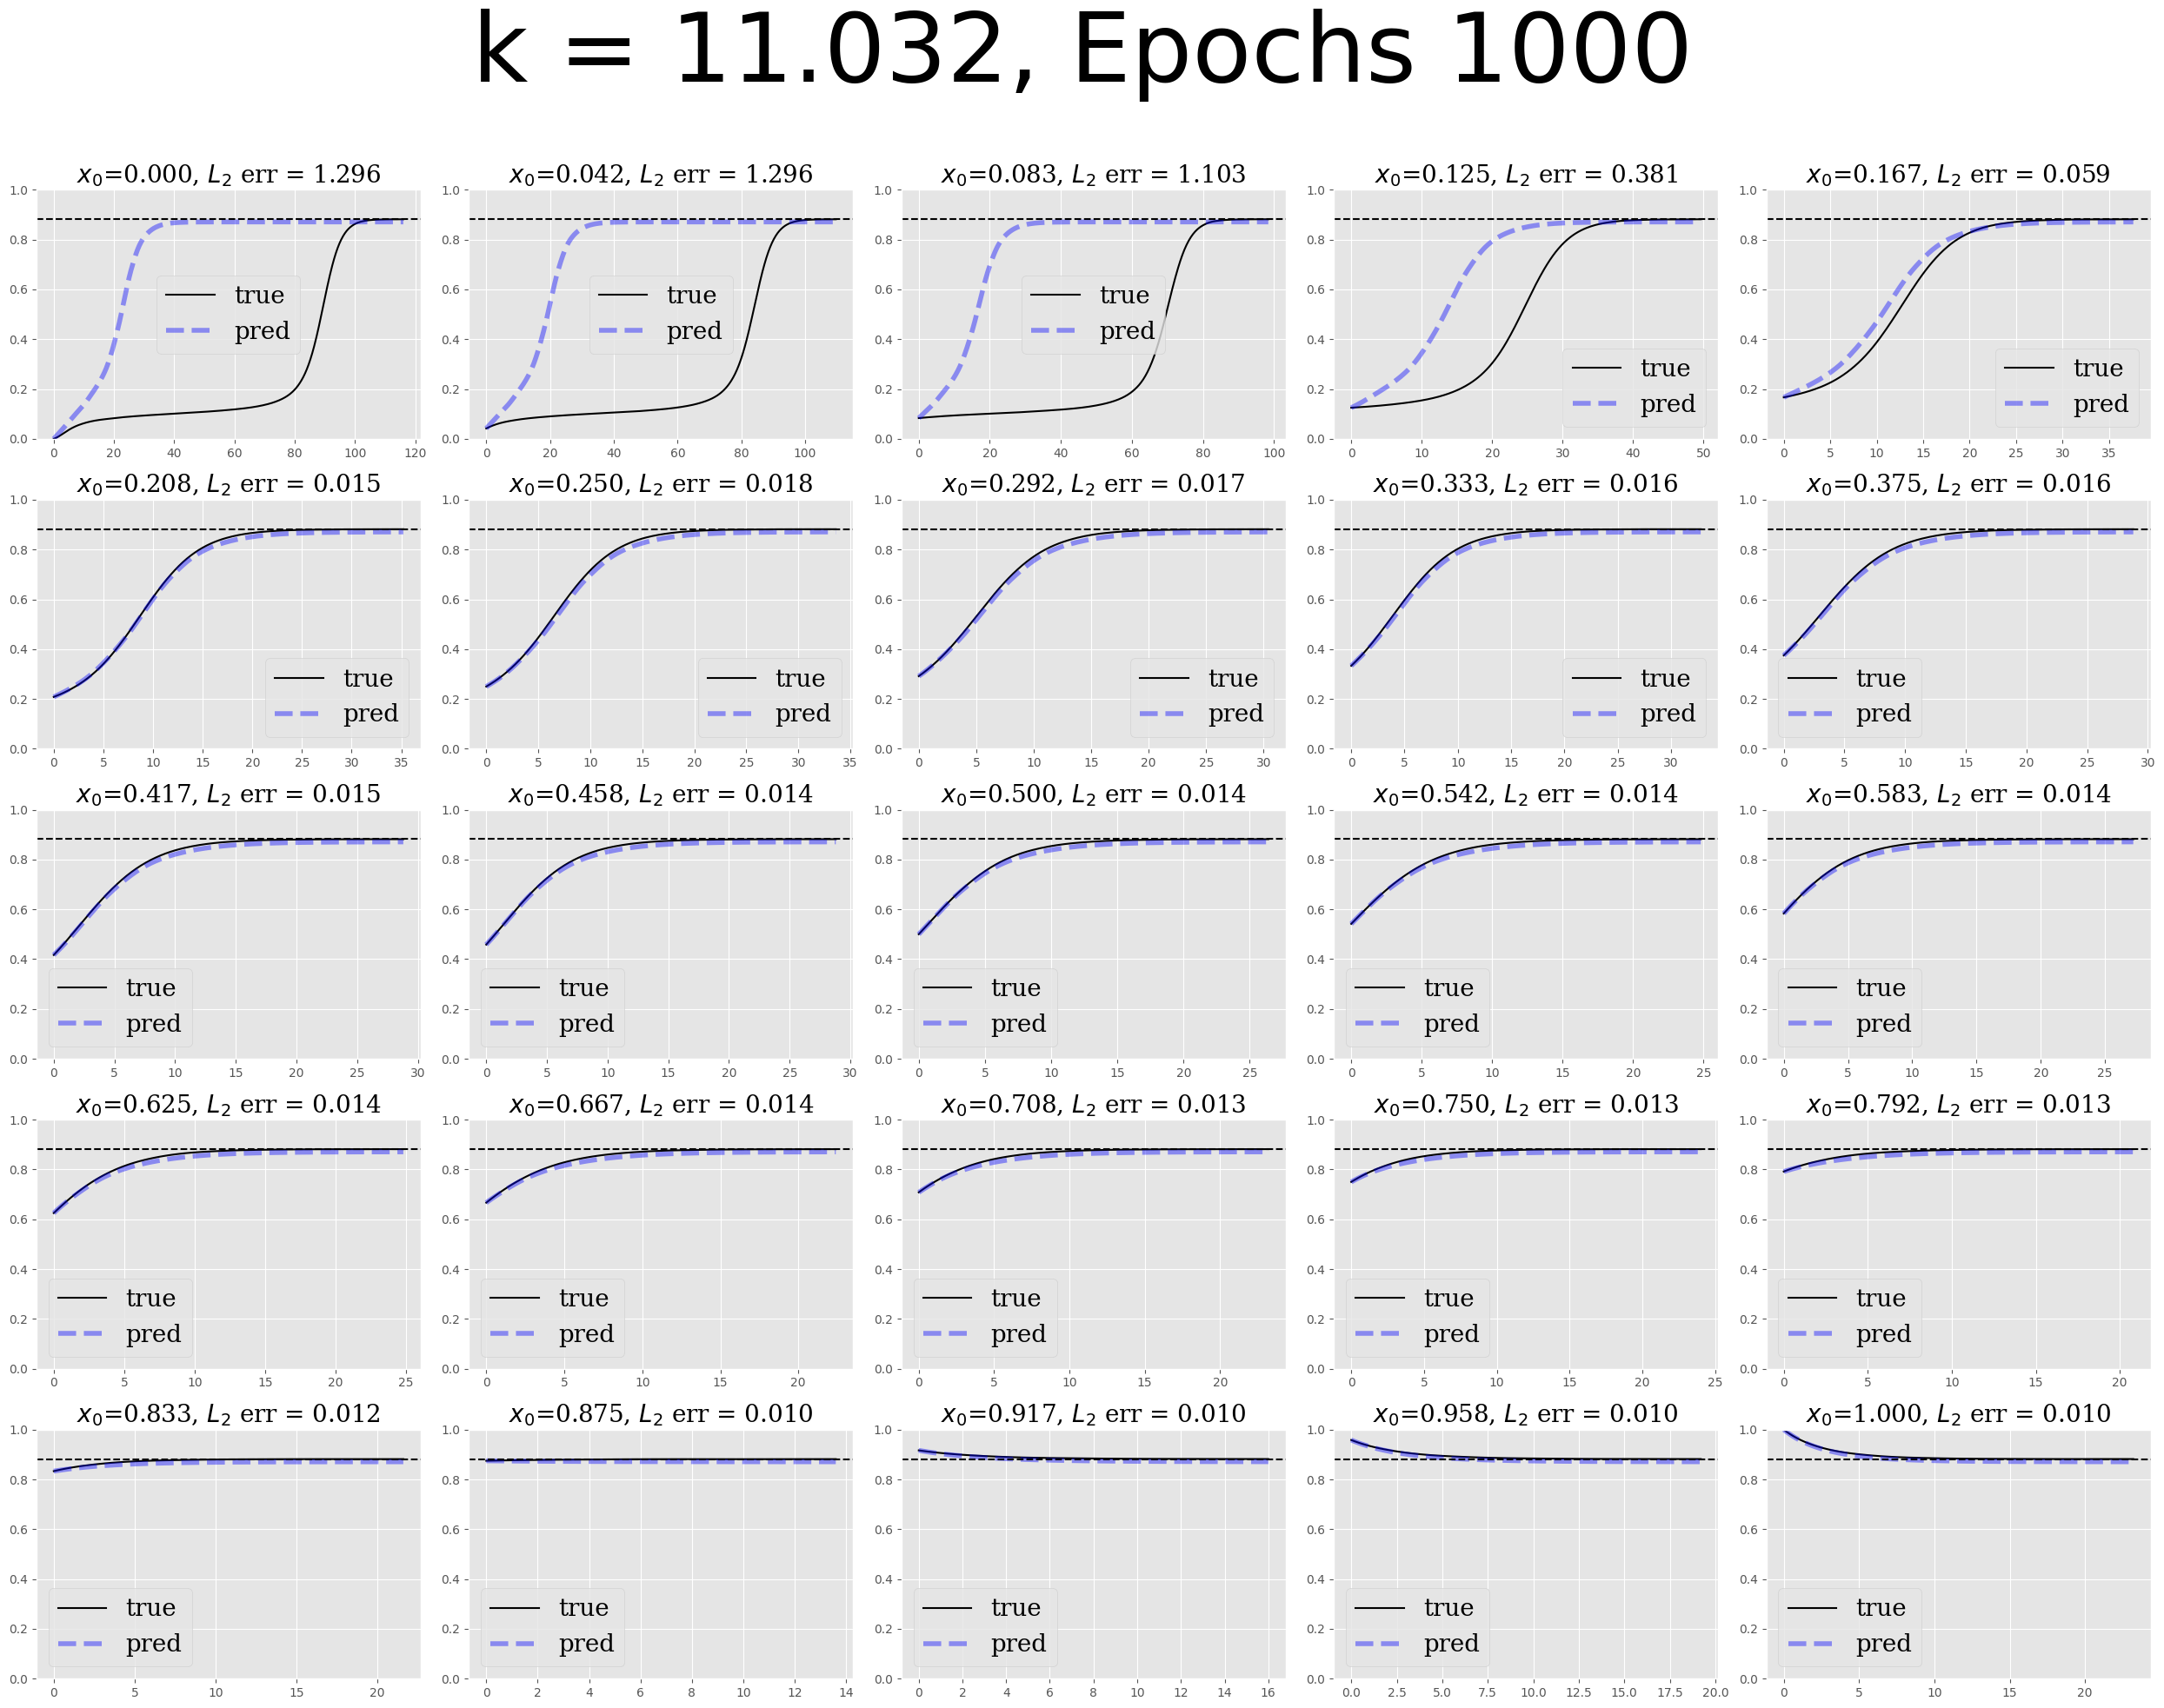

In [92]:

i=19 # to plot the trajectories for trial i 
cols = 5
rows = int(np.ceil(len(range(indices[i], indices[i+1]))/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()
k_val = None
# control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(indices[i], indices[i+1])):
        ax = axs[idx - indices[i]]
        xi, ti, x0i,ki = train_dataset[idx]
        xi = xi.squeeze() # [batch, time, dim]
        ti = ti.squeeze()
        k_val = ki
        ki = ki.view(1)
        x0i = x0i.view(-1,1)

        # print(xi.shape, ti.shape)

        control_func = lambda t: ki
        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i,
            t_eval=ti,
            method="tsit5"
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i.squeeze().cpu().numpy():.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        scaled_steady_states = scaler.transform(np.array(budworm_steady_states(ki.squeeze(),r=0.56)).reshape(-1,1)).reshape(-1)
        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(range(indices[i], indices[i+1])), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"k = {k_val.squeeze().numpy():.3f}, Epochs {1000}", size=80)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()
